In [1]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from collections import namedtuple
from multiprocessing import Pool
from itertools import repeat

from definitions import ROOT_DIR
from unc.utils import load_info

In [2]:
level = 4
all_paths = {
#     f'uf{level}a_cnn': Path(ROOT_DIR, 'results', f'uf{level}a_cnn'),
    f'uf{level}m_cnn':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn'),
#     f'uf{}_cnn_lstm':  Path(ROOT_DIR, 'results', f'uf{level}m_cnn_lstm'),

}

plot_info = {
    f'uf{level}a_cnn': {'color': 'forestgreen', 'label': 'Ground-truth map'},
    f'uf{level}m_cnn_lstm': {'color': 'darkred', 'label': 'LSTM + normal mapping'},
    f'uf{level}m_cnn_uncertainty_decay_1.0': {'color': 'black', 'label': 'Normal mapping'},
    f'uf{level}m_cnn_uncertainty_decay_0.9': {'color': 'darkorange', 'label': 'Normal mapping + uncertainty'}
}

plot_order = [
#     f'uf{level}a_cnn',
    f'uf{level}m_cnn_uncertainty_decay_1.0',
#     f'uf{level}m_cnn_lstm',
    f'uf{level}m_cnn_uncertainty_decay_0.9'
]
split_by = ['buffer_size', 'step_size', 'arch', 'uncertainty_decay', 'slip_prob']
Args = namedtuple('args', split_by)


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [3]:
def process_dir(dir_path, split_by, w=10):
    all_results = {}

        
    for f in tqdm(list(dir_path.iterdir())):
        info = load_info(f)
        args = info['args'].item()
        if "arch" not in args:
            args['arch'] = 'nn'
        
        reward = info['reward']
        offline_reward = info['offline_eval_reward']

        hparams = Args(*tuple(args[s] for s in split_by))

        if hparams not in all_results:
            all_results[hparams] = []

        all_results[hparams].append((reward, offline_reward, args, f))

    
    return all_results

    

In [4]:
def group_by(dataset, key, label_head, arrayify=True):
    grouped_data = {}
    for args, d in dataset.items():
        key_val = getattr(args, key)
        full_label = label_head + f'_{key}_{key_val}'
        if full_label not in grouped_data:
            grouped_data[full_label] = {}
        
        grouped_data[full_label][args] = d
    return grouped_data

In [5]:
raw_data = {}

for key, v in all_paths.items():
    processed = process_dir(v, split_by)
    raw_data[key] = processed

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
key = 'uncertainty_decay'
split_files = [f'uf{level}m_cnn']
new_raw = {}

for split_file in split_files:
    new_grouped = group_by(raw_data[split_file], key, split_file)
    for k, v in new_grouped.items():
        new_raw[k] = v
for k, v in raw_data.items():
    if k not in split_files:
        new_raw[k] = v

In [8]:
no_slip_raw = {}
slip_raw = {}

for k, v in new_raw.items():
    new_v_slip = {}
    new_v_no_slip = {}
    
    for k_arg, v_arg in v.items():
        if k_arg.slip_prob > 0.:
            new_v_slip[k_arg] = v_arg
        else:
            new_v_no_slip[k_arg] = v_arg
    slip_raw[k] = new_v_slip
    no_slip_raw[k] = new_v_no_slip

In [9]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data.items():
        final_max = np.mean([np.mean(offline_rew) for online_rew, offline_rew, all_args, fname in all_dis_rew])
        fnames = [fname for _, _, _, fname in all_dis_rew]
        hparam_results.append((args, final_max, fnames))
    return hparam_results



In [12]:
slip_raw

{'uf4m_cnn_uncertainty_decay_1.0': {args(buffer_size=100000, step_size=1e-05, arch='cnn', uncertainty_decay=1.0, slip_prob=0.1): [(None,
    array([[ 0.,  0.,  0.,  0.,  0.],
           [ 3.,  0., 17.,  0., 10.],
           [ 7.,  5.,  5.,  5., 12.],
           ...,
           [12., 15., 19., 21., 13.],
           [12., 13., 10., 14., 15.],
           [18., 13., 12., 20., 11.]]),
    {'same_k_rnn_params': False,
     'test_eps': 0.0,
     'distance_unc_encoding': False,
     'view_test_ep': False,
     'slip_turn': False,
     'k_rnn_hs': 1,
     'distance_noise': False,
     'half_efficiency_distance': 20.0,
     'seed': 2022,
     'step_size': 1e-05,
     'task_fname': 'fishing_{}_config.json',
     'discounting': 0.9,
     'n_particles': -1,
     'action_cond': None,
     'slip_prob': 0.1,
     'uncertainty_decay': 1.0,
     'arch': 'cnn',
     'count_decay': 1.0,
     'v_min': -10,
     'platform': 'gpu',
     'results_fname': 'ba4b070e22c82150501bc6eea4f289fb_Thu May  5 22:29:46 2

In [13]:
max_overs_slip = {}
max_overs_no_slip = {}

for g, v in slip_raw.items():
    max_overs_slip[g] = get_eps_max_over(v, eps_max_over=100)
    
# for g, v in no_slip_raw.items():
#     max_overs_no_slip[g] = get_eps_max_over(v, eps_max_over=100)

In [14]:
# Get the best hyperparams based on the final 100 episodes
all_best_slip = {}
for key, v in max_overs_slip.items():
    all_best_slip[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

# all_best_no_slip = {}
# for key, v in max_overs_no_slip.items():
#     all_best_no_slip[key] = sorted(v, key=lambda x : x[1], reverse=True)[0]

all_best_slip

{'uf4m_cnn_uncertainty_decay_1.0': (args(buffer_size=100000, step_size=1e-05, arch='cnn', uncertainty_decay=1.0, slip_prob=0.1),
  13.041333333333334,
  [PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn/ba4b070e22c82150501bc6eea4f289fb_Thu May  5 22:29:46 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn/9a1ad8f92d29a103731fe141860c048b_Thu May  5 22:29:46 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn/76fb0660fb67e6d3a2c24579a3ac9e55_Thu May  5 22:29:46 2022.npy')]),
 'uf4m_cnn_uncertainty_decay_0.9': (args(buffer_size=100000, step_size=1e-05, arch='cnn', uncertainty_decay=0.9, slip_prob=0.1),
  19.941599999999998,
  [PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn/b99ccb6cb1f81a8c927935c2eb3a82e7_Fri May  6 01:59:15 2022.npy'),
   PosixPath('/home/taodav/Documents/uncertainty/results/uf4m_cnn/4a9110d2a8a188c5469da944476d8e33_Fri May  6 01:54:07 2022.npy'),
   PosixPath('/home/taodav/Documents/unce

In [31]:
# alg_dir_map = {
#     'uf2m_cnn_uncertainty_decay_0.9': 'uf2m_cnn',
#     'uf2m_cnn_uncertainty_decay_1.0': 'uf2m_cnn',
#     'uf2a_cnn': 'uf2a_cnn',
#     'uf2p_cnn_lstm': 'uf2p_cnn_lstm',
#     'uf2m_cnn_lstm': 'uf2m_cnn_lstm'
# }
# for alg, values in all_best.items():
#     arg, offline_mean, fnames = values
#     results_dir = Path(ROOT_DIR, 'results')
#     dir_to_append = results_dir / alg_dir_map[alg]

#     for f in fnames:
#         shutil.copy(f, dir_to_append)
    
    

In [32]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode


# def map_dis_rew_to_steps(data, w=1000, trunc=1e6):
#     all_seeds = []
#     for offline_rews, online_rews, _ in data:
#         current_seed = []
#         for length, dis_rew in zip(lengths, dis_rews):
#             current_seed.append(np.zeros(length) + dis_rew)
#         all_seeds.append(moving_avg(np.concatenate(current_seed)[:trunc], w=w))
#     return np.array(all_seeds)

In [15]:
# trunc = int(1e6)
all_mapped_data_slip = {}
for key, v in all_best_slip.items():
    arg = v[0]
#     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
    all_seeds = [val[1].mean(axis=-1) for val in slip_raw[key][arg]]
    all_mapped_data_slip[key] = np.stack(all_seeds)
    
# all_mapped_data_no_slip = {}
# for key, v in all_best_no_slip.items():
#     arg = v[0]
# #     all_mapped_data[key] = map_dis_rew_to_steps(new_raw[key][arg], trunc=trunc)
#     all_seeds = [val[1].mean(axis=-1) for val in no_slip_raw[key][arg]]
#     all_mapped_data_no_slip[key] = np.stack(all_seeds)



In [16]:
all_mapped_data_slip

{'uf4m_cnn_uncertainty_decay_1.0': array([[ 0. ,  6. ,  6.8, ..., 16. , 12.8, 14.8],
        [ 5.6, 10. , 10.4, ..., 14.2, 14.8, 16.6],
        [ 2. ,  2.6,  6.2, ..., 15.6, 12.4, 12.8]]),
 'uf4m_cnn_uncertainty_decay_0.9': array([[ 5. , 10. , 10.8, ..., 26.6, 20. , 21.4],
        [ 8. ,  6.6,  0. , ..., 22.8, 20.2, 22. ],
        [ 8.4,  9.8, 10.8, ..., 22.6, 21.2, 22.8]])}

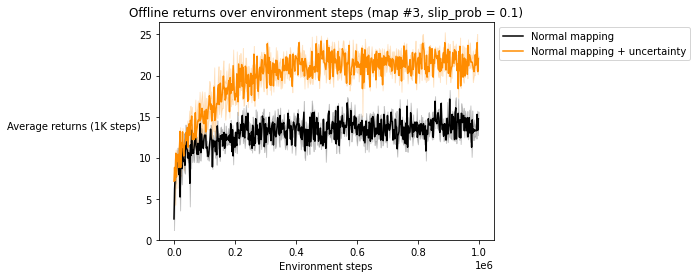

In [17]:
# with slip
fig, ax = plt.figure(), plt.axes()
steps_per_eval = 2000


for k in plot_order:
    data = all_mapped_data_slip[k]
    key = plot_info[k]['label']
    color = plot_info[k]['color']
    x = np.arange(data.shape[1]) * steps_per_eval

    means = data.mean(axis=0)
    std_err = data.std(axis=0) / np.sqrt(data.shape[0])

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Average returns (1K steps)", rotation=0, labelpad=65)
ax.set_title(f'Offline returns over environment steps (map #3, slip_prob = 0.1)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')